In [67]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [68]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [69]:
import tensorflow as tf

In [70]:
tf.__version__

'2.0.0'

In [71]:
# To generate GIFs
!pip install imageio

You should consider upgrading via the 'pip install --upgrade pip' command.


In [72]:
# To use Differential Privacy
!pip install tensorflow_privacy

You should consider upgrading via the 'pip install --upgrade pip' command.


In [73]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers, models
import time

from IPython import display

from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
from tensorflow_privacy.privacy.optimizers.dp_optimizer import DPGradientDescentGaussianOptimizer
from tensorflow_privacy.privacy.optimizers.dp_optimizer import DPAdamGaussianOptimizer

## Modified Optimizer

In [183]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from absl import logging

import tensorflow as tf

import collections

from tensorflow_privacy.privacy.analysis import privacy_ledger
from tensorflow_privacy.privacy.dp_query import gaussian_query
from tensorflow_privacy.privacy.dp_query import no_privacy_query


def make_optimizer_class(cls):
  """Constructs a DP optimizer class from an existing one."""
  parent_code = tf.compat.v1.train.Optimizer.compute_gradients.__code__
  child_code = cls.compute_gradients.__code__
  GATE_OP = tf.compat.v1.train.Optimizer.GATE_OP  # pylint: disable=invalid-name
  if child_code is not parent_code:
    logging.warning(
        'WARNING: Calling make_optimizer_class() on class %s that overrides '
        'method compute_gradients(). Check to ensure that '
        'make_optimizer_class() does not interfere with overridden version.',
        cls.__name__)

  class DPOptimizerClass(cls):
    """Differentially private subclass of given class cls."""

    _GlobalState = collections.namedtuple(
      '_GlobalState', ['l2_norm_clip', 'stddev'])
    
    def __init__(
        self,
        dp_sum_query,
        num_microbatches=None,
        unroll_microbatches=False,
        *args,  # pylint: disable=keyword-arg-before-vararg, g-doc-args
        **kwargs):
      """Initialize the DPOptimizerClass.

      Args:
        dp_sum_query: DPQuery object, specifying differential privacy
          mechanism to use.
        num_microbatches: How many microbatches into which the minibatch is
          split. If None, will default to the size of the minibatch, and
          per-example gradients will be computed.
        unroll_microbatches: If true, processes microbatches within a Python
          loop instead of a tf.while_loop. Can be used if using a tf.while_loop
          raises an exception.
      """
      super(DPOptimizerClass, self).__init__(*args, **kwargs)
      self._dp_sum_query = dp_sum_query
      self._num_microbatches = num_microbatches
      self._global_state = self._dp_sum_query.initial_global_state()
      # TODO(b/122613513): Set unroll_microbatches=True to avoid this bug.
      # Beware: When num_microbatches is large (>100), enabling this parameter
      # may cause an OOM error.
      self._unroll_microbatches = unroll_microbatches

    def compute_gradients(self,
                          loss,
                          var_list,
                          gate_gradients=GATE_OP,
                          aggregation_method=None,
                          colocate_gradients_with_ops=False,
                          grad_loss=None,
                          gradient_tape=None,
                          SET_noise=0,
                          SET_clip=10):

      self._dp_sum_query = gaussian_query.GaussianSumQuery(SET_clip, SET_clip*SET_noise)
      self._global_state = self._dp_sum_query.make_global_state(SET_clip, SET_clip*SET_noise)
      



      # TF is running in Eager mode, check we received a vanilla tape.
      if not gradient_tape:
        raise ValueError('When in Eager mode, a tape needs to be passed.')

      vector_loss = loss()
      if self._num_microbatches is None:
        self._num_microbatches = tf.shape(input=vector_loss)[0]
      sample_state = self._dp_sum_query.initial_sample_state(var_list)
      microbatches_losses = tf.reshape(vector_loss, [self._num_microbatches, -1])
      sample_params = (self._dp_sum_query.derive_sample_params(self._global_state))

      def process_microbatch(i, sample_state):
        """Process one microbatch (record) with privacy helper."""
        microbatch_loss = tf.reduce_mean(input_tensor=tf.gather(microbatches_losses, [i]))
        grads = gradient_tape.gradient(microbatch_loss, var_list)
        sample_state = self._dp_sum_query.accumulate_record(sample_params, sample_state, grads)
        return sample_state
    
      for idx in range(self._num_microbatches):
        sample_state = process_microbatch(idx, sample_state)

      if SET_noise > 0:
        grad_sums, self._global_state = (self._dp_sum_query.get_noised_result(sample_state, self._global_state))
      else:
        grad_sums = sample_state

      def normalize(v):
        return v / tf.cast(self._num_microbatches, tf.float32)

      final_grads = tf.nest.map_structure(normalize, grad_sums)
      grads_and_vars = final_grads#list(zip(final_grads, var_list))
    
      return grads_and_vars

  return DPOptimizerClass


def make_gaussian_optimizer_class(cls):
  """Constructs a DP optimizer with Gaussian averaging of updates."""

  class DPGaussianOptimizerClass(make_optimizer_class(cls)):
    """DP subclass of given class cls using Gaussian averaging."""

    def __init__(
        self,
        l2_norm_clip,
        noise_multiplier,
        num_microbatches=None,
        ledger=None,
        unroll_microbatches=False,
        *args,  # pylint: disable=keyword-arg-before-vararg
        **kwargs):
      dp_sum_query = gaussian_query.GaussianSumQuery(
          l2_norm_clip, l2_norm_clip * noise_multiplier)

      if ledger:
        dp_sum_query = privacy_ledger.QueryWithLedger(dp_sum_query,
                                                      ledger=ledger)

      super(DPGaussianOptimizerClass, self).__init__(
          dp_sum_query,
          num_microbatches,
          unroll_microbatches,
          *args,
          **kwargs)

    @property
    def ledger(self):
      return self._dp_sum_query.ledger

  return DPGaussianOptimizerClass

GradientDescentOptimizer = tf.compat.v1.train.GradientDescentOptimizer
DPGradientDescentGaussianOptimizer_NEW = make_gaussian_optimizer_class(GradientDescentOptimizer)

## START

In [184]:
base_dir = '/storage/TF2'

In [313]:
name_trial = '/tousemicro'

result_dir = base_dir + '/GANPoster' + name_trial

In [314]:
# Define checkpoint dir and prefix
checkpoint_dir = result_dir + '/training_checkpoints'

def checkpoint_name(title):  
  checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt__" + str(title))
  return(checkpoint_prefix)

In [315]:
images_dir = result_dir + '/images'

def generate_and_save_images(model, epoch, test_input, test_label):
  # Notice `training` is set to False: This is so all layers run in inference mode (batchnorm).
  predictions = model([test_input, test_label], training=False)

  fig = plt.figure(figsize=(2,10))

  for i in range(predictions.shape[0]):
      plt.subplot(10, 1, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig(images_dir + '/image_at_epoch_{:04d}.png'.format(epoch))
  #plt.show()

In [316]:
if not os.path.exists(result_dir):
  os.makedirs(result_dir)

if not os.path.exists(checkpoint_dir):
  os.makedirs(checkpoint_dir)

if not os.path.exists(images_dir):
  os.makedirs(images_dir)

## C-GAN

In [318]:
def make_generator_model_FCC():
    # INPUT: label input
    in_label = layers.Input(shape=(COND_num_classes,))

    # INPUT: image generator input
    in_lat = layers.Input(shape=(Z_DIM,))

    # MERGE
    merge = layers.concatenate([in_lat, in_label], axis=1)

    ge1 = layers.Dense(128, use_bias=True)(merge)
    ge1 = layers.ReLU()(ge1)

    ge2 = layers.Dense(784, use_bias=True, activation="tanh")(ge1)
    out_layer = layers.Reshape((28, 28, 1))(ge2)

    model = models.Model([in_lat, in_label], out_layer)

    return model

def make_discriminator_model_FCC():
    # INPUT: Label
    in_label = layers.Input(shape=(COND_num_classes,))

    # INPUT: Image
    in_image = layers.Input(shape=(28, 28, 1))
    in_image_b = layers.Flatten()(in_image)

    # MERGE
    merge = layers.concatenate([in_image_b, in_label], axis=1)

    ge1 = layers.Dense(128, use_bias=True)(merge)
    ge1 = layers.ReLU()(ge1)

    out_layer = layers.Dense(1, use_bias=True)(ge1)

    model = models.Model([in_image, in_label], out_layer)

    return model

## SETUP

In [319]:
# SETUP
COND_num_classes = 10

Z_DIM = 100 # Does NOT affect EPSILON
NORM_CLIP = 1.1 # Does NOT affect EPSILON, but increases NOISE on gradients

DP_DELTA = 1e-5

NOISE_MULT = 1.15
EPOCHS = 249

BUFFER_SIZE = 60000

BATCH_SIZE = 600

N_DISC = 1

In [320]:
# Obtain DP_EPSILON
compute_dp_sgd_privacy.compute_dp_sgd_privacy(n = BUFFER_SIZE, 
                                              batch_size = BATCH_SIZE, 
                                              noise_multiplier = NOISE_MULT, 
                                              epochs = EPOCHS, 
                                              delta = DP_DELTA)

DP-SGD with sampling rate = 1% and noise_multiplier = 1.15 iterated over 24900 steps satisfies differential privacy with eps = 9.64 and delta = 1e-05.
The optimal RDP order is 4.0.


(9.643695567594444, 4.0)

In [321]:
# SD of noise
NOISE_MULT*NORM_CLIP

1.265

In [351]:
generator = make_generator_model_FCC()
discriminator = make_discriminator_model_FCC()

In [352]:
#generator.summary()

In [353]:
#discriminator.summary()

(1, 100)
(1, 10)
tf.Tensor([[0.04091578]], shape=(1, 1), dtype=float32)


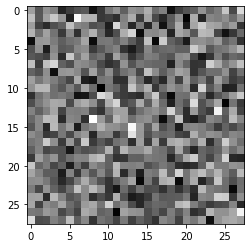

In [354]:
###################
## MODELS
# Test GEN created
noise = tf.Variable(tf.random.normal([1, Z_DIM]))
noise_label = tf.Variable(np.array([0,0,1,0,0,0,0,0,0,0], dtype='float32').reshape((1,10)))
print(noise.shape)
print(noise_label.shape)
generated_image = generator([noise, noise_label], training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

# Test DISC created
decision = discriminator([generated_image, noise_label])
print(decision)

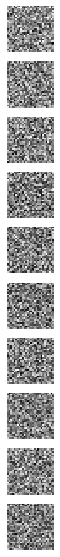

In [355]:
tf.random.set_seed(1)
num_examples_to_generate = 10
# We will reuse this seed overtime (so it's easier) to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, Z_DIM])
seed_labels = tf.Variable(np.array([1,0,0,0,0,0,0,0,0,0]*1 + 
                                   [0,1,0,0,0,0,0,0,0,0]*1 +
                                   [0,0,1,0,0,0,0,0,0,0]*1 +
                                   [0,0,0,1,0,0,0,0,0,0]*1 +
                                   [0,0,0,0,1,0,0,0,0,0]*1 +
                                   [0,0,0,0,0,1,0,0,0,0]*1 +
                                   [0,0,0,0,0,0,1,0,0,0]*1 +
                                   [0,0,0,0,0,0,0,1,0,0]*1 +
                                   [0,0,0,0,0,0,0,0,1,0]*1 +
                                   [0,0,0,0,0,0,0,0,0,1]*1, dtype='float32').reshape((10,10)))

generate_and_save_images(generator, 0, seed, seed_labels)

### GOOD

In [356]:
import tensorflow.keras.backend as K

In [357]:
###################
## OPTIMIZERS
generator_optimizer = tf.keras.optimizers.Adam()

lr_disc = tf.compat.v1.train.polynomial_decay(learning_rate=0.150,
                                              global_step=tf.compat.v1.train.get_or_create_global_step(),
                                              decay_steps=10000,
                                              end_learning_rate=0.052,
                                              power=1)

discriminator_optimizer = DPGradientDescentGaussianOptimizer_NEW(
   learning_rate = lr_disc,
   l2_norm_clip = NORM_CLIP,
   noise_multiplier = NOISE_MULT,
   num_microbatches = 1)

# DP
cross_entropy_DISC = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.losses.Reduction.NONE)

# Not-DP
cross_entropy_GEN = tf.keras.losses.BinaryCrossentropy(from_logits=True)

###################
## LOSS AND UPDATES

# Notice the use of `tf.function`: This annotation causes the function to be "compiled".
@tf.function
def train_step_DISC_BOTH(images, labels, noise):    
    with tf.GradientTape(persistent=True) as disc_tape_real:
      # This dummy call is needed to obtain the var list.
      dummy = discriminator([images, labels], training=True)
      var_list = discriminator.trainable_variables

      # In Eager mode, the optimizer takes a function that returns the loss.
      def loss_fn_real():
        real_output = discriminator([images, labels], training=True)
        disc_real_loss = cross_entropy_DISC(tf.ones_like(real_output), real_output)
        return disc_real_loss
      
      grads_and_vars_real = discriminator_optimizer.compute_gradients(loss_fn_real, var_list, 
                                                                      gradient_tape=disc_tape_real, 
                                                                      SET_noise=NOISE_MULT,
                                                                      SET_clip=NORM_CLIP)
      
      # In Eager mode, the optimizer takes a function that returns the loss.
      def loss_fn_fake():
        generated_images = generator([noise, labels], training=True)
        fake_output = discriminator([generated_images, labels], training=True)
        disc_fake_loss = cross_entropy_DISC(tf.zeros_like(fake_output), fake_output)
        return disc_fake_loss
      
      grads_and_vars_fake = discriminator_optimizer.compute_gradients(loss_fn_fake, var_list, 
                                                                      gradient_tape=disc_tape_real,
                                                                      SET_noise=0,
                                                                      SET_clip=NORM_CLIP)
    
    norm_r = 0 #tf.linalg.global_norm(grads_and_vars_real)
    norm_f = 0 #tf.linalg.global_norm(grads_and_vars_fake)
        
    s_grads_and_vars = [(grads_and_vars_real[idx] + grads_and_vars_fake[idx]) for idx in 
                        range(len(grads_and_vars_real))]
    sanitized_grads_and_vars = list(zip(s_grads_and_vars, var_list))
    
    discriminator_optimizer.apply_gradients(sanitized_grads_and_vars)
    
    return(norm_r, norm_f)


################################################################################################
################################################################################################

# Notice the use of `tf.function`: This annotation causes the function to be "compiled".
@tf.function
def train_step_GEN(labels, noise):
    with tf.GradientTape() as gen_tape:
      generated_images = generator([noise, labels], training=True)
      fake_output = discriminator([generated_images, labels], training=True)
      # if the generator is performing well, the discriminator will classify the fake images as real (or 1)
      gen_loss = cross_entropy_GEN(tf.ones_like(fake_output), fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    return(gen_loss)

## TRAIN

In [358]:
# CREATE CHECKPOINT STRUCTURE
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [359]:
def train(dataset, title):
  for epoch in range(EPOCHS):
    start = time.time()

    i_gen = 0
    for image_batch, label_batch in dataset:
      noise = tf.random.normal([BATCH_SIZE, Z_DIM])
      #print(str(i_gen) + " ------------------------------------------------------ ")
      d_r, d_f = train_step_DISC_BOTH(image_batch, label_batch, noise)
      #print("------ NORM REAL: " + str(d_r))
      #print("------ NORM FAKE: " + str(d_f))
      
      #if (i_gen + 1) % N_DISC == 0:
      g_f = train_step_GEN(label_batch, noise)
      
      i_gen = i_gen + 1

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                              epoch + 1,
                              seed,
                              seed_labels)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Save the model
    checkpoint.save(file_prefix = checkpoint_name(title + "__epoch=" + str(epoch) + "__"))

## Dataset

In [360]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [364]:
print(train_images.shape)
train_labels = train_labels.reshape((60000, 1))
print(train_labels.shape)

(60000, 28, 28, 1)
(60000, 1)


In [365]:
train_labels_vec = np.zeros((len(train_labels), COND_num_classes), dtype='float32')
for i, label in enumerate(train_labels):
    train_labels_vec[i, int(train_labels[i])] = 1.0
print(train_labels_vec.shape)
train_labels_vec[:5,:]

(60000, 10)


array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

# Train

In [366]:
tf.random.set_seed(1)
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels_vec)).shuffle(BUFFER_SIZE, reshuffle_each_iteration=True).batch(BATCH_SIZE, drop_remainder=True)

In [367]:
training_title = 'eps9.6'

In [ ]:
train(train_dataset, training_title)

In [321]:
tf.constant(11)

<tf.Tensor: id=2286400, shape=(), dtype=int32, numpy=11>

## Classification

In [ ]:
checkpoint_dir

In [369]:
checkpoint.restore('/storage/TF2/GANPoster/tousemicro/training_checkpoints/ckpt__eps9.6__epoch=248__-249')

In [370]:
tf.random.set_seed(100)
N_GEN = 5000
N_GEN_per_CLASS = np.int(N_GEN/10)

noise_GEN = tf.random.normal([N_GEN, Z_DIM])
labels_GEN = tf.Variable(np.array([1,0,0,0,0,0,0,0,0,0]*N_GEN_per_CLASS + 
                                   [0,1,0,0,0,0,0,0,0,0]*N_GEN_per_CLASS +
                                   [0,0,1,0,0,0,0,0,0,0]*N_GEN_per_CLASS +
                                   [0,0,0,1,0,0,0,0,0,0]*N_GEN_per_CLASS +
                                   [0,0,0,0,1,0,0,0,0,0]*N_GEN_per_CLASS +
                                   [0,0,0,0,0,1,0,0,0,0]*N_GEN_per_CLASS +
                                   [0,0,0,0,0,0,1,0,0,0]*N_GEN_per_CLASS +
                                   [0,0,0,0,0,0,0,1,0,0]*N_GEN_per_CLASS +
                                   [0,0,0,0,0,0,0,0,1,0]*N_GEN_per_CLASS +
                                   [0,0,0,0,0,0,0,0,0,1]*N_GEN_per_CLASS, 
                                   dtype='float32').reshape((N_GEN,10)))

In [371]:
images_GEN = generator([noise_GEN, labels_GEN], training=False)
images_tt = layers.Flatten()(images_GEN)

In [372]:
labels_tt = tf.Variable(np.array([0]*N_GEN_per_CLASS + 
                                   [1]*N_GEN_per_CLASS +
                                   [2]*N_GEN_per_CLASS +
                                   [3]*N_GEN_per_CLASS +
                                   [4]*N_GEN_per_CLASS +
                                   [5]*N_GEN_per_CLASS +
                                   [6]*N_GEN_per_CLASS +
                                   [7]*N_GEN_per_CLASS +
                                   [8]*N_GEN_per_CLASS +
                                   [9]*N_GEN_per_CLASS, 
                                   dtype='float32').reshape((N_GEN,1)))

In [373]:
print(labels_tt.shape)
images_tt.shape

(5000, 1)


TensorShape([5000, 784])

In [375]:
Y_train = labels_tt[:images_tt.shape[0]]
X_train = images_tt

### Validation Results

In [376]:
!pip install sklearn

You should consider upgrading via the 'pip install --upgrade pip' command.


In [377]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import label_binarize
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils.testing import ignore_warnings
from sklearn.preprocessing import LabelBinarizer

In [ ]:
def compute_fpr_tpr_roc(Y_test, Y_score):
    n_classes = Y_score.shape[1]
    false_positive_rate = dict()
    true_positive_rate = dict()
    roc_auc = dict()
    for class_cntr in range(n_classes):
        false_positive_rate[class_cntr], true_positive_rate[class_cntr], _ = roc_curve(Y_test[:, class_cntr],
                                                                                       Y_score[:, class_cntr])
        roc_auc[class_cntr] = auc(false_positive_rate[class_cntr], true_positive_rate[class_cntr])

    # Compute micro-average ROC curve and ROC area
    false_positive_rate["micro"], true_positive_rate["micro"], _ = roc_curve(Y_test.ravel(), Y_score.ravel())
    roc_auc["micro"] = auc(false_positive_rate["micro"], true_positive_rate["micro"])

    return false_positive_rate, true_positive_rate, roc_auc

In [ ]:
tf.random.set_seed(1)
classifier_LR = OneVsRestClassifier(LogisticRegression(solver='lbfgs', 
                                                       multi_class='multinomial', 
                                                       random_state=2))
Y_score = classifier_LR.fit(X_train, Y_train).predict_proba(X_train)
false_positive_rate, true_positive_rate, roc_auc = compute_fpr_tpr_roc(np.array(Y_train), Y_score)
[str(au) + " = " + str(roc_auc[au]) for au in roc_auc]

In [ ]:
tf.random.set_seed(1)
classifier_NN = OneVsRestClassifier(MLPClassifier(random_state=2, alpha=1))

Y_score = classifier_NN.fit(X_train, Y_train).predict_proba(X_train)
false_positive_rate, true_positive_rate, roc_auc = compute_fpr_tpr_roc(np.array(Y_train), Y_score)
[str(au) + " = " + str(roc_auc[au]) for au in roc_auc]

### Test Results

In [378]:
(_, _), (X_test_org, Y_test_org) = tf.keras.datasets.mnist.load_data()

X_test_org = X_test_org.reshape(X_test_org.shape[0], 28, 28, 1).astype('float32')
X_test_org = (X_test_org - 127.5) / 127.5 # Normalize the images to [-1, 1]
#X_test_org = X_test_org[(Y_test_org == 4) | (Y_test_org == 9)]
print(X_test_org.shape)

#Y_test_org = Y_test_org[(Y_test_org == 4) | (Y_test_org == 9)]
#Y_test_org = np.array([int(y==4) for y in Y_test_org])


Y_test_org = [int(y) for y in Y_test_org]
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Y_test_org = label_binarize(Y_test_org, classes=classes)

print(Y_test_org.shape)

X_test = layers.Flatten()(X_test_org)
Y_test = layers.Flatten()(Y_test_org)
print(X_test.shape)
print(Y_test.shape)

(10000, 28, 28, 1)
(10000, 10)
(10000, 784)
(10000, 10)


In [ ]:
tf.random.set_seed(1)
classifier_LR = OneVsRestClassifier(LogisticRegression(solver='lbfgs', 
                                                       multi_class='multinomial', 
                                                       random_state=2))
Y_score = classifier_LR.fit(X_train, Y_train).predict_proba(X_test)
false_positive_rate, true_positive_rate, roc_auc = compute_fpr_tpr_roc(np.array(Y_test), Y_score)
[str(au) + " = " + str(roc_auc[au]) for au in roc_auc]

In [ ]:
tf.random.set_seed(1)
classifier_NN = OneVsRestClassifier(MLPClassifier(random_state=2, alpha=1))

Y_score = classifier_NN.fit(X_train, Y_train).predict_proba(X_test)
false_positive_rate, true_positive_rate, roc_auc = compute_fpr_tpr_roc(np.array(Y_test), Y_score)
[str(au) + " = " + str(roc_auc[au]) for au in roc_auc]

In [ ]:
from sklearn import metrics

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return metrics.roc_auc_score(y_test, y_pred, average=average)

In [ ]:
tf.random.set_seed(1)
classifier_NN = OneVsRestClassifier(MLPClassifier(random_state=2, alpha=1))
classifier_NN.fit(X_train, Y_train)

Y_score = classifier_NN.predict(X_test)

print(multiclass_roc_auc_score(Y_test, Y_score))
print(metrics.classification_report(Y_test, Y_score))